Let's create `macrograd` from scratch following Andrej Karpathy's guide

In [1]:
# This is all we need to create macrograd
# Amazing, isn't it?
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Using `graphviz` to visualize the computation graph
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
class Value:
    
    def __init__(self, data, _op=None, _children=(), label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self._prev = set(_children)
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _op='+', _children={self, other})
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(other.data + self.data, _op='+', _children=(self, other))
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _op='*', _children={self, other})
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, _op='-', _children=(self, other))
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        
        return out

    def __rsub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(other.data - self.data, _op='-', _children=(self, other))
        
        def _backward():
            self.grad += -1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, n):
        out = Value(self.data ** n, _op='^', _children=(self,))
        
        def _backward():
            self.grad += n * (self.data ** (n - 1)) * out.grad
        out._backward = _backward
        
        return out


    def tanh(self):
        out = Value(math.tanh(self.data), _op='tanh', _children=(self,))
        
        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        # this is topological sorting (in Graph theory)
        # not topological order (in Physics - Quantum Mechanics)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    
    def zero_grad(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for v in topo:
            v.grad = 0.0


In [4]:
# build a expression

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label="f")
L = d * f; L.label = 'L'

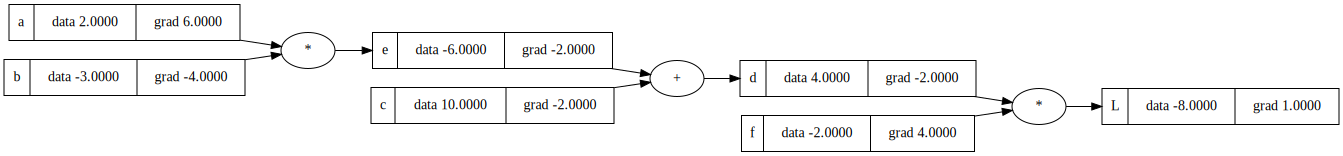

In [6]:
draw_dot(L)

In [5]:
L.zero_grad()
L.backward()

In [7]:
# Now, we can build a Neuron to train
import random


class Neuron:

    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # x -> w * x + b -> tanh -> output
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz) - 1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [8]:
# example of training

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired target

model = MLP(3, [4, 4, 1])

In [19]:
for k in range(10):
    # forward pass
    ypred = [model(x) for x in xs]
    loss = sum((yi - yi_pred) ** 2 for yi, yi_pred in zip(ys, ypred))

    # backward pass
    loss.zero_grad()
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.006725609110886576
1 0.006637914602106972
2 0.006552409073157659
3 0.006469012716554385
4 0.006387649524135788
5 0.006308247065012735
6 0.0062307362788395024
7 0.0061550512831917365
8 0.006081129193944803
9 0.006008909957643887


In [20]:
ypred

[Value(data=0.9584219823616669),
 Value(data=-0.9721840725505386),
 Value(data=-0.9543397540251446),
 Value(data=0.9622959614291473)]